In [32]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [33]:
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings
import kaggler

In [34]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [35]:
data_dir = Path('./Dacon')
feature_dir = Path('./Dacon/feature')
sub_dir = Path('./Dacon/sub')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
seed = 42

In [36]:
algo_name = 'lgb'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [37]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(319820, 19)


,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
id,,,,,,,,,,,,,,,,,,,
0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,18,1.1898,1.1907,1.1890,1.1894,1.1902,0
1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1,1.2533,1.2578,1.2488,1.2510,1.2555,1
2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,2,1.0225,1.0241,1.0210,1.0217,1.0233,0
3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,4,3,1.2054,1.2061,1.2049,1.2051,1.2057,0
4,24.4534,20.6992,19.0424,18.3242,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,13,12,1.1939,1.1943,1.1937,1.1938,1.1941,0


In [38]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000]
tst = pd.read_csv(tst_file, index_col=0)
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(319820,) (319820, 18) (80000, 18)


In [39]:
tst

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z
id,,,,,,,,,,,,,,,,,,
320000,19.1431,18.0172,17.4733,17.1144,16.9263,1.2130e-01,19.0750,17.9550,17.4308,17.0838,16.9087,1,1,1.1563,1.1515,1.1613,1.1588,1.1539
320001,18.7409,17.1705,16.3691,15.9865,15.7307,-6.6907e-05,15.0703,14.3098,14.3901,14.5160,14.6372,2,2,1.0076,1.0074,1.0080,1.0078,1.0075
320002,19.2980,17.8803,17.2221,16.8096,16.6352,1.1001e-01,19.1004,17.7726,17.1460,16.7497,16.5689,1,1,1.3809,1.3905,1.3715,1.3761,1.3856
320003,18.0775,17.1569,16.9041,16.8118,16.7955,2.9697e-05,17.9729,17.0735,16.8470,16.7700,16.7668,1,1,1.1408,1.1408,1.1409,1.1408,1.1408
320004,17.8325,16.7646,16.2135,15.8722,15.6621,6.8471e-02,17.7545,16.6794,16.1563,15.8315,15.6433,2,2,1.1110,1.1077,1.1145,1.1127,1.1093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,19.6734,18.6617,18.2708,18.1225,18.0627,-3.1726e-04,19.3361,18.3933,18.0860,17.9861,17.9670,17,17,1.1858,1.1863,1.1855,1.1857,1.1861
399996,21.5229,20.7283,20.6087,21.0049,20.8458,6.5455e-02,21.3993,20.6399,20.5451,20.9507,20.7827,8,4,1.2850,1.2908,1.2793,1.2821,1.2878
399997,19.3991,18.2411,18.1605,18.1978,18.2018,-8.4180e-04,18.9136,17.8753,17.9047,18.0043,18.0400,1,1,1.1885,1.1886,1.1885,1.1885,1.1885


In [40]:
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.2, random_state=seed)
print(X_trn.shape, X_val.shape, y_trn.shape, y_val.shape)

(255856, 18) (63964, 18) (255856,) (63964,)


In [49]:
clf = lgb.LGBMClassifier(objective='multiclass',
                         n_estimators=10000,
                         num_leaves=64,
                         learning_rate=0.05,
                         min_child_samples=10,
                         subsample=.5,
                         subsample_freq=1,
                         colsample_bytree=.8,
                         random_state=seed,
                         n_jobs=-1)
clf.fit(X_trn, y_trn,
        eval_set=[(X_val, y_val)],
        eval_metric='multiclass',
        early_stopping_rounds=10)
p_val = clf.predict(X_val)
p_tst = clf.predict(tst)

[1]	valid_0's multi_logloss: 0.927467
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.866021
[3]	valid_0's multi_logloss: 0.815024
[4]	valid_0's multi_logloss: 0.774812
[5]	valid_0's multi_logloss: 0.729854
[6]	valid_0's multi_logloss: 0.693221
[7]	valid_0's multi_logloss: 0.65865
[8]	valid_0's multi_logloss: 0.627389
[9]	valid_0's multi_logloss: 0.596594
[10]	valid_0's multi_logloss: 0.568958
[11]	valid_0's multi_logloss: 0.548304
[12]	valid_0's multi_logloss: 0.530596
[13]	valid_0's multi_logloss: 0.509894
[14]	valid_0's multi_logloss: 0.488688
[15]	valid_0's multi_logloss: 0.469313
[16]	valid_0's multi_logloss: 0.452575
[17]	valid_0's multi_logloss: 0.439566
[18]	valid_0's multi_logloss: 0.425362
[19]	valid_0's multi_logloss: 0.410713
[20]	valid_0's multi_logloss: 0.400464
[21]	valid_0's multi_logloss: 0.39309
[22]	valid_0's multi_logloss: 0.382293
[23]	valid_0's multi_logloss: 0.37052
[24]	valid_0's multi_logloss: 0.363165
[25]	valid_0's 

[208]	valid_0's multi_logloss: 0.179211
[209]	valid_0's multi_logloss: 0.179161
[210]	valid_0's multi_logloss: 0.179149
[211]	valid_0's multi_logloss: 0.179128
[212]	valid_0's multi_logloss: 0.179082
[213]	valid_0's multi_logloss: 0.179058
[214]	valid_0's multi_logloss: 0.179044
[215]	valid_0's multi_logloss: 0.179001
[216]	valid_0's multi_logloss: 0.178989
[217]	valid_0's multi_logloss: 0.178941
[218]	valid_0's multi_logloss: 0.178917
[219]	valid_0's multi_logloss: 0.178899
[220]	valid_0's multi_logloss: 0.178807
[221]	valid_0's multi_logloss: 0.17873
[222]	valid_0's multi_logloss: 0.178704
[223]	valid_0's multi_logloss: 0.178698
[224]	valid_0's multi_logloss: 0.178675
[225]	valid_0's multi_logloss: 0.17869
[226]	valid_0's multi_logloss: 0.178644
[227]	valid_0's multi_logloss: 0.17861
[228]	valid_0's multi_logloss: 0.178597
[229]	valid_0's multi_logloss: 0.178526
[230]	valid_0's multi_logloss: 0.17848
[231]	valid_0's multi_logloss: 0.178459
[232]	valid_0's multi_logloss: 0.178431
[233

[414]	valid_0's multi_logloss: 0.174712
[415]	valid_0's multi_logloss: 0.174708
[416]	valid_0's multi_logloss: 0.174703
[417]	valid_0's multi_logloss: 0.174668
[418]	valid_0's multi_logloss: 0.174656
[419]	valid_0's multi_logloss: 0.174642
[420]	valid_0's multi_logloss: 0.174635
[421]	valid_0's multi_logloss: 0.17461
[422]	valid_0's multi_logloss: 0.174589
[423]	valid_0's multi_logloss: 0.174591
[424]	valid_0's multi_logloss: 0.174581
[425]	valid_0's multi_logloss: 0.174548
[426]	valid_0's multi_logloss: 0.174532
[427]	valid_0's multi_logloss: 0.17453
[428]	valid_0's multi_logloss: 0.174504
[429]	valid_0's multi_logloss: 0.174502
[430]	valid_0's multi_logloss: 0.174469
[431]	valid_0's multi_logloss: 0.174452
[432]	valid_0's multi_logloss: 0.174446
[433]	valid_0's multi_logloss: 0.174425
[434]	valid_0's multi_logloss: 0.174413
[435]	valid_0's multi_logloss: 0.174402
[436]	valid_0's multi_logloss: 0.174394
[437]	valid_0's multi_logloss: 0.174371
[438]	valid_0's multi_logloss: 0.174361
[4

In [50]:
print(f'{accuracy_score(y_val, p_val) * 100:.4f}%')


92.8241%


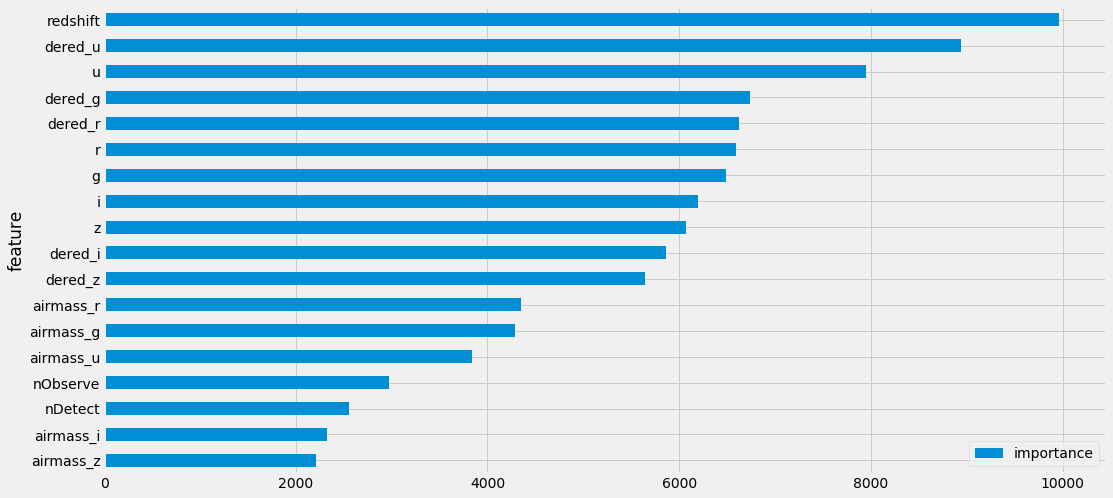

In [46]:
imp = pd.DataFrame({'feature': trn.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')